# First Test

Very simple 1D model to try the integration of empymod into SimPEG.

**Limiations at this point:**

- Inversion only for infinitesimal small x-directed electric source and receiver (ab == 11)
- Frequency domain, using lagged convolution type digital linear filters
- Inversion only for resistivity ($\rho_h$), hence fixed values for anisotropy ($\lambda$), electric permeabilities ($\epsilon_h$, $\epsilon_v$) and magnetic permeabilities ($\mu_h$, $\mu_v$)
- Fixed depth structure (ont inverting for layer thicknesses)
- No `numexpr`, no looping
- *Only one frequency and one offset? Or several frequencies, one offset? Or several offsets, one frequency?*
- Start with numerical derivatives. Hunziker et al. (2016) published the code iEMmod which contains the analytical derivatives for the case ef electric source and receivers, so it should not be too difficult to include at a later point the analytical derivatives into empymod. (I might start that in parallel.)


**Other considerations**

- SimPEG supports, I think, Python 2.7 and 3+, however, empymod only supports Python 3.4, 3.5, 3.6.

The example uses 6 offsets (hence 6 complex values), and the inversion model has 21 free layers (including the lower halfspace), so 21 parameters (as we only invert for resistivity at this time).

In [1]:
# I was playing around with this on Azure, so needed the install step
# !pip install SimPEG
# !pip install empymod

In [2]:
import numpy as np
from scipy import optimize
from copy import deepcopy as dc
import matplotlib.pyplot as plt
from scipy.constants import mu_0, epsilon_0

import SimPEG
import empymod

## 1. Forward model, create data

Lets define a simple forward model to generate some data, the canonical CSEM model (e.g., Constable and Weiss, 2006). We define only the minimum required input, and leave everything else at its default value.

### 1.1 Define model and create data

**Note** I changed the model to make it a bit easier for our first go around :) 

The resistive layer is now closer to the surface and thicker

In [3]:
depth = [ 0, 1000, 1600, 1900] # Layer boundaries
res =   [2e14, .3, 1, 100, 1]  # Air, sea, overburden, target, underburden
freq = 1                       # 1 Hz
src = [0, 0, 900]              # Src coordinates
x = np.arange(4, 16)*500       # Offsets
rec = [x, x*0, 1000]           # Rec coordinates

data = empymod.dipole(src, rec, depth, res, freq)

# Lets also calculate a denser model and the background, just to compare it
xf = np.arange(1, 80)*100       # Offsets
rec2 = [xf, xf*0, rec[2]]
full = empymod.dipole(src, rec2, depth, res, freq)
bg = empymod.dipole(src, rec2, depth[:-2], res[:-2], freq)


:: empymod END; runtime = 0:00:00.162049 :: 1 kernel call(s)


:: empymod END; runtime = 0:00:00.025368 :: 1 kernel call(s)


:: empymod END; runtime = 0:00:00.017310 :: 1 kernel call(s)



### 1.2 Add some noise data

Add 1 % random error and a noise level of 10e-15 V/m.

In [4]:
# Generate noise
mask = 1e-2*(1.5 - np.random.random_sample(data.shape))
maskn = 1e-15*(1.5 - np.random.random_sample(data.shape))

# Apply noise
datan = data*(1 + mask) + maskn

### 1.3 Plot model and data

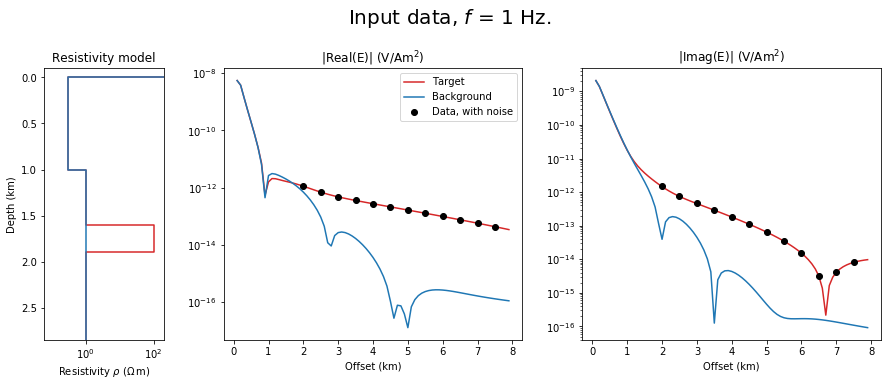

In [5]:
# Create arrays for resistivity model
pdepth = np.repeat(np.r_[-100, depth], 2)
pdepth[:-1] = pdepth[1:]
pdepth[-1] = 2*depth[-1]
pres = np.repeat(res, 2)
presBG = np.repeat(res[:-2], 2)

# Create figure
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(wspace=.5)
plt.suptitle('Input data, $f$ = '+str(freq)+' Hz.', y=1.05, fontsize=20)

# Plot Resistivities
plt.subplot(151)
plt.title('Resistivity model')
plt.plot(pres, pdepth/1000, 'C3', label='Target')
plt.plot(presBG, np.r_[pdepth[:-5], pdepth[-1]]/1000, 'C0', label='BG')
plt.xscale('log')
plt.xlim([.2*np.array(res).min(), 2*np.array(res)[1:].max()])
plt.ylim([1.5*depth[-1]/1000, -0.1])
plt.ylabel('Depth (km)')
plt.xlabel(r'Resistivity $\rho\ (\Omega\,\rm{m})$')

# Plot Amplitude
plt.subplot2grid((1, 5), (0, 1), colspan=2)
plt.title(r'|Real(E)| (V/Am$^2$)')
plt.semilogy(xf/1000, np.abs(full.real), 'C3', label='Target')
plt.semilogy(xf/1000, np.abs(bg.real), 'C0', label='Background')
plt.semilogy(x/1000, np.abs(datan.real), 'ko', label='Data, with noise')
plt.legend(loc='best')
plt.xlabel('Offset (km)')

# Plot Phase
plt.subplot2grid((1, 5), (0, 3), colspan=2)
plt.title(r'|Imag(E)| (V/Am$^2$)')
plt.semilogy(xf/1000, np.abs(full.imag), 'C3', label='Target')
plt.semilogy(xf/1000, np.abs(bg.imag), 'C0', label='Background')
plt.semilogy(x/1000, np.abs(datan.imag), 'ko', label='Data, with noise')
plt.xlabel('Offset (km)')

plt.show()

## 2. Define inverse model

The main user-facing routines of `empymod` are `model.dipole` and `model.bipole`. However, they do a lot of stuff we want to avoid in an inversion scheme, such as input checks and timing.

In [6]:
# Define the inversion model: 20 layers, plus air, sea, and lower half-space
idepth = np.r_[-np.infty, 0, 1000+np.arange(6)*300] 

# Initial resistivities (starting model resistivity)
sres = np.ones(idepth.shape)
sres[:2] = [2e14, 0.3]  # Air and water resistivity
ires = dc(sres)

# Calc zeta (isotropic)
zeta = np.ones((1, len(idepth)))*2j*np.pi*freq*mu_0

# Model parameters which we do not invert for (at the moment, at least)
fixed_params = {
    'zsrc': np.array(src[2]),
    'zrec': np.array(rec[2]),
    'lsrc': 1,
    'lrec': 1,
    'off': x,
    'angle': x*0,        # Angles (0, as we have y=0)
    'depth': idepth,
    'ab': 11,            # El., x-directed source and receivers
    'freq': np.array(freq),
    'zetaH': zeta,
    'zetaV': zeta,
    'msrc': False,       # Electric source
    'mrec': False,       # Electric receivers
}

# Stuff we don't touch at the moment and keep fixed
settings = {
    'isfullspace': False,
    'xdirect': False,                                 # Direct field in the wavenumber domain
    'ht': 'fht',                                      # FHT (digital linear filter)
    'htarg': (empymod.filters.key_201_2009(), None),  # Default FHT arguments
    'use_spline': True,                               # Lagged convolution
    'use_ne_eval': False,                             # Do not use `numexpr`
    'loop_freq': False,
    'loop_off': False,
    'conv': True
}

# Define a simple routine to calculate one forward model based only on resistivity
def calc_fm(res, fixed_params=fixed_params, settings=settings):

    # Calculate eta (isotropic)
    eta = np.atleast_2d(1/res + 2j*np.pi*freq*epsilon_0)
    print(eta.shape)

    # Calculate result
    out, _, _ = empymod.model.fem(etaH=eta, etaV=eta, **fixed_params, **settings)
    return np.squeeze(out)

# Get start model
startm = calc_fm(sres)

# Now we have the data in
print('Responses from the data:\n', data)

# The starting model in
print('\nResponses given the starting model:\n', startm)

# An the starting resistivities
print('\nStarting resistivities (without air, sea):\n', sres[2:])

(1, 8)
Responses from the data:
 [ -1.11161075e-12 -1.45927163e-12j  -6.89350816e-13 -7.44344128e-13j
  -4.70950920e-13 -4.54919822e-13j  -3.51769805e-13 -2.89130848e-13j
  -2.70699299e-13 -1.81380963e-13j  -2.09678560e-13 -1.10722179e-13j
  -1.62493228e-13 -6.45461585e-14j  -1.25665831e-13 -3.45199117e-14j
  -9.67904665e-14 -1.52362354e-14j  -7.41193422e-14 -3.15637932e-15j
  -5.63445700e-14 +4.08481236e-15j  -4.24586059e-14 +8.09665616e-15j]

Responses given the starting model:
 [ -6.90102509e-13 +3.94771438e-14j  -9.19393811e-14 +1.59986490e-13j
   2.63511215e-14 +4.51612926e-14j   1.64457322e-14 +1.29917389e-16j
   3.55204054e-15 -4.34870579e-15j   1.03269121e-16 -1.79386169e-15j
   1.11576635e-17 -4.57949813e-16j   2.27023797e-16 -1.81045698e-16j
   2.56541656e-16 -1.70169547e-16j   2.07305928e-16 -1.61100137e-16j
   1.59167238e-16 -1.34941427e-16j   1.26497060e-16 -1.08717233e-16j]

Starting resistivities (without air, sea):
 [ 1.  1.  1.  1.  1.  1.]


## 3. Inversion

I think this is now where `SimPEG` comes in. The inversion should now adjust `ires[2:]` (if we exclude air and sea layers) after given rules.

1. Calculate RMS
2. Calculate sensitivity
3. Adjust ires[2:] given certain rules
4. Re-calculate response

In [7]:
# ires[11:14] = [25, 50, 25]  # "Manual inversion"
# inv = calc_fm(ires)         # Re-calculate

### 3.2 Very rudimentary `scipy` implementation

Misses regularization, weighting, basically everything. Just out of interest.

In [8]:
def cost_fct(invres, dat):
    """Cost function, very crude implementation."""
    # Calculate eta (isotropic); first three and last layers fixed
    eta = np.atleast_2d(1/np.r_[2e14, 0.3, 1, 10**invres, 1] + 2j*np.pi*freq*epsilon_0)

    # Calculate result
    out, _, _ = empymod.model.fem(etaH=eta, etaV=eta, **fixed_params, **settings)
    out = np.squeeze(out)
    
    # Very crude minimization function, no weighting whatsoever; assuming 1 % data error
    out = np.sum(((np.real(dat)-np.real(out))**2 + (np.imag(dat)-np.imag(out))**2)/np.abs(dat*.01)**2)

    return out


def dcost_fct(invres, dat):
    """Calculate gradient of the cost function, very basic implementation too."""

    resdiff = 1e-3  # Difference to calculate gradient
    
    # Pre-allocate
    out = np.zeros(invres.shape)
    
    # Loop over free layers
    for i, val in enumerate(invres):
        pres = dc(invres)
        mres = dc(invres)
        pres[i] = val + resdiff
        mres[i] = val - resdiff
        out[i] = (cost_fct(pres, dat) - cost_fct(mres, dat))/(2*resdiff)
        
    return out

# Try BFGS; first three and last layers fixed
ires = 10**optimize.fmin_bfgs(cost_fct, np.log10(sres[3:-1]), dcost_fct, (datan,))

# Calculate final model
ires = np.r_[2e14, 0.3, 1, ires, 1]
inv = calc_fm(ires)

         Current function value: 144.301507
         Iterations: 65
         Function evaluations: 153
         Gradient evaluations: 143
(1, 8)


## 4. Plot inversion result

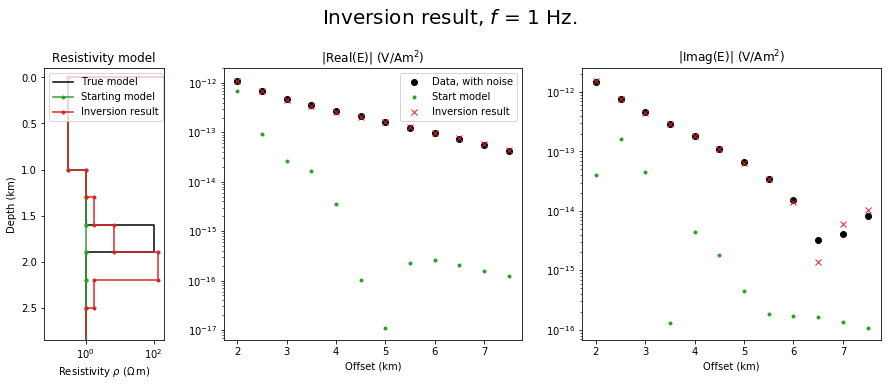

In [9]:
# Create arrays for resistivity model
ipdepth = np.repeat(idepth, 2)
ipdepth[:-1] = ipdepth[1:]
ipdepth[-1] = 2*idepth[-1]

spres = np.repeat(sres, 2)
ipres = np.repeat(ires, 2)

# Create figure
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(wspace=.5)
plt.suptitle('Inversion result, $f$ = '+str(freq)+' Hz.', y=1.05, fontsize=20)

# Plot Resistivities
plt.subplot(151)
plt.title('Resistivity model')
plt.plot(pres, pdepth/1000, 'k', label='True model')
plt.plot(spres, ipdepth/1000, 'C2.-', label='Starting model')
plt.plot(ipres, ipdepth/1000, 'C3.-', label='Inversion result')
plt.xscale('log')
plt.xlim([.2*np.array(res).min(), 2*np.array(res)[1:].max()])
plt.ylim([1.5*depth[-1]/1000, -0.1])
plt.legend(loc=2)
plt.ylabel('Depth (km)')
plt.xlabel(r'Resistivity $\rho\ (\Omega\,\rm{m})$')

# Plot Amplitude
plt.subplot2grid((1, 5), (0, 1), colspan=2)
plt.title(r'|Real(E)| (V/Am$^2$)')
plt.semilogy(x/1000, np.abs(datan.real), 'ko', label='Data, with noise')
plt.semilogy(x/1000, np.abs(startm.real), 'C2.', label='Start model')
plt.semilogy(x/1000, np.abs(inv.real), 'C3x', label='Inversion result')
plt.legend(loc='best')
plt.xlabel('Offset (km)')

# Plot Phase
plt.subplot2grid((1, 5), (0, 3), colspan=2)
plt.title(r'|Imag(E)| (V/Am$^2$)')
plt.semilogy(x/1000, np.abs(datan.imag), 'ko', label='Data, with noise')
plt.semilogy(x/1000, np.abs(startm.imag), 'C2.', label='Start model')
plt.semilogy(x/1000, np.abs(inv.imag), 'C3x', label='Inversion result')
plt.xlabel('Offset (km)')

plt.show()

# SimPEG wrapper class for an empymod problem

In [10]:
# this is sketching out an idea for later... we can chat! 

# import properties

# class EmpymodParameters(properties.HasProperties):
    
#     zsrc = properties.Array("z location of the source", default=np.r_[10])

In [11]:
from SimPEG.Problem import BaseProblem
from SimPEG import Props

class EmpymodProblem(BaseProblem):
    """
    Problem class for a simulation conducted with empymod
    """
    
    rho, rho_map, rho_deriv = Props.Invertible(
        "Electrical Resistivity (Ohm m)"
    ) 
    
    deleteTheseOnModelUpdate = ['_Japprox']
    
    # Stuff we don't touch at the moment and keep fixed
    empymod_settings = {
        'isfullspace': False,
        'xdirect': False,                                 # Direct field in the wavenumber domain
        'ht': 'fht',                                      # FHT (digital linear filter)
        'htarg': (empymod.filters.key_201_2009(), None),  # Default FHT arguments
        'use_spline': True,                               # Lagged convolution
        'use_ne_eval': False,                             # Do not use `numexpr`
        'loop_freq': False,
        'loop_off': False,
        'conv': True
    }
    
    def __init__(self, mesh, **kwargs):
        assert mesh.dim == 1, "only 1D modelling supported"
        super(EmpymodProblem, self).__init__(mesh, **kwargs)
        
        # set air at infinity
        depth = self.mesh.gridN.copy()
        depth[0] = -np.inf
        
        # set the empymod_fixedparams
        zeta = np.ones((1, len(depth)))*2j*np.pi*freq*mu_0
        self.fixed_params = {
            'zsrc': np.array(src[2]),
            'zrec': np.array(rec[2]),
            'lsrc': 1,
            'lrec': 1,
            'off': x,
            'angle': x*0,        # Angles (0, as we have y=0)
            'depth': depth,
            'ab': 11,            # El., x-directed source and receivers
            'freq': np.array(freq),
            'zetaH': zeta,
            'zetaV': zeta,
            'msrc': False,       # Electric source
            'mrec': False,       # Electric receivers
        }
    
    def _calc_fm(self, rho):
        """
        compute data using empymod. The real and imaginary parts are separated so that 
        we are always working with real values
        """
        
        # Calculate eta (isotropic)
        eta = np.atleast_2d(1/rho + 2j*np.pi*freq*epsilon_0)
        
        # Calculate result
        out, _, _ = empymod.model.fem(etaH=eta, etaV=eta, **self.fixed_params, **self.empymod_settings)
        out = np.squeeze(out) 
        return np.hstack([out.real, out.imag])  
        
    def fields(self, m):
        """
        Computes the fields
        """
        
        # set the model (this performs the mappings)
        self.model = m
        return self._calc_fm(self.rho)
    
    def Japprox(self, m, perturbation=0.1, min_perturbation=1e-3):
        """
        Approximate sensitivity computed using a finite difference approach
        """
        if getattr(self, '_Japprox', None) is None:
            self.model = m 
            delta_m = min_perturbation # np.max([perturbation*m.mean(), min_perturbation])

            J = []

            for i, entry in enumerate(m):
                mpos = m.copy()
                mpos[i] = entry + delta_m
                
                mneg = m.copy()
                mneg[i] = entry - delta_m
                
                pos = self._calc_fm(self.rho_map * mpos)
                neg = self._calc_fm(self.rho_map * mneg)
                J.append((pos - neg) / (2.*delta_m))

            self._Japprox = np.vstack(J).T
            
        return self._Japprox
    
    def Jvec(self, m, v, f=None):
        """
        Sensitivity times a vector
        """
        self.model = m
        return self.Japprox(m).dot(v)

    def Jtvec(self, m, v, f=None):
        """
        Adjoint Sensitivity times a vector
        """
        self.model = m
        return self.Japprox(m).T.dot(v)

    
class EmpymodSurvey(SimPEG.Survey.BaseSurvey):
    """
    Survey class for a simulation conducted with empymod
    """
    
    @property 
    def nD(self):
        # this will likely need to be generalized
        return len(self.prob.fixed_params['off']) * 2
        
    def eval(self, f):
        return f
      

## Tests
- **forward** make sure we can reproduce initial results
- **Jvec** test sensitivity computation

In [12]:
# this is something we can work on cleaning up - simpeg needs a mesh for the forward problem,
# working with infinity is tricky, so I make it finite here and swap it out for an inf in 
# the instantiation of the problem 

finite_air_z = 1000
true_depth = depth.copy()
true_depth = np.hstack([np.r_[-finite_air_z], true_depth])
meshfwd = SimPEG.Mesh.TensorMesh([np.diff(true_depth)], x0=[-finite_air_z])

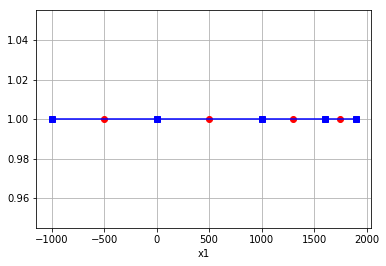

In [13]:
# plot the mesh
meshfwd.plotGrid(nodes=True, centers=True)

Here, we set up mappings - we will invert for log(resistivity) below the sea floor

In [14]:
# for the inversion, we want to ignore air and probably the sea layers
# and invert for log-resistivity 

exp_map_fwd = SimPEG.Maps.ExpMap(nP=len(res))
inject_active_cells_fwd = SimPEG.Maps.InjectActiveCells(
    meshfwd, 
    np.arange(2, len(res)),  # active indices (eg layers we want to invert for)
    np.log(res[:2]),  # log-resistivity values of the inactive cells
    nC=len(res)
)

In [15]:
# create the problem object
probfwd = EmpymodProblem(meshfwd, rho_map=exp_map_fwd * inject_active_cells_fwd)

In [16]:
# start with the true model and compute data 

m = np.log(res[2:])
fields = probfwd.fields(m)

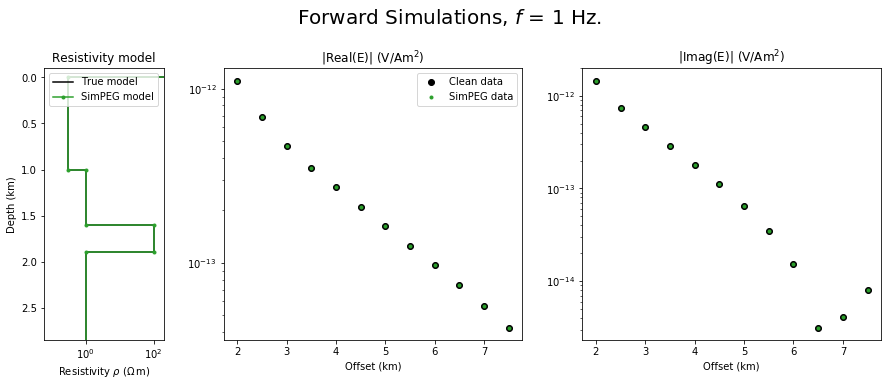

In [17]:
# Plot Resistivities
prho = np.repeat(probfwd.rho, 2) # resistivities from SimPEG model

# Create figure
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(wspace=.5)
plt.suptitle('Forward Simulations, $f$ = '+str(freq)+' Hz.', y=1.05, fontsize=20)

# plot resistivities
plt.subplot(151)
plt.title('Resistivity model')
plt.plot(pres, pdepth/1000, 'k', label='True model')
plt.plot(prho, pdepth/1000, 'C2.-', label='SimPEG model')
plt.xscale('log')
plt.xlim([.2*np.array(res).min(), 2*np.array(res)[1:].max()])
plt.ylim([1.5*depth[-1]/1000, -0.1])
plt.legend(loc=2)
plt.ylabel('Depth (km)')
plt.xlabel(r'Resistivity $\rho\ (\Omega\,\rm{m})$')

# Plot Amplitude
plt.subplot2grid((1, 5), (0, 1), colspan=2)
plt.title(r'|Real(E)| (V/Am$^2$)')
plt.semilogy(x/1000, np.abs(data.real), 'ko', label='Clean data')
plt.semilogy(x/1000, np.abs(fields[:len(data)]), 'C2.', label='SimPEG data')
plt.legend(loc='best')
plt.xlabel('Offset (km)')

# Plot Phase
plt.subplot2grid((1, 5), (0, 3), colspan=2)
plt.title(r'|Imag(E)| (V/Am$^2$)')
plt.semilogy(x/1000, np.abs(data.imag), 'ko', label='Clean data')
plt.semilogy(x/1000, np.abs(fields[len(data):]), 'C2.', label='SimPEG data')
plt.xlabel('Offset (km)')

plt.show()

## Test the sensitivities

Work with a 20 layer model, check that the sensitivities are second order

In [18]:
from SimPEG import Tests

In [19]:
finite_air_z = 1000
seafloor = depth[1]
nlayers = 20
last_layer = 3000  # depth of last layer

h = (last_layer-seafloor)/nlayers  # layer thicknesses

# create a mesh
inversion_depths = np.hstack([
    np.r_[-finite_air_z, 0.], 
    np.arange(seafloor, last_layer+h, h)
])
simpeg_depths = np.diff(inversion_depths)
mesh = SimPEG.Mesh.TensorMesh([simpeg_depths], x0=[-finite_air_z])

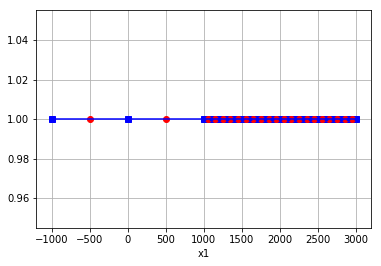

In [20]:
mesh.plotGrid(nodes=True, centers=True)

In [21]:
# mappings and problem 

exp_map = SimPEG.Maps.ExpMap(nP=nlayers+3)
inject_active_cells = SimPEG.Maps.InjectActiveCells(
    mesh, 
    2+np.arange(0, nlayers+1),  # active indices (eg layers we want to invert for)
    np.log(ires[:2]),  # log-resistivity values of the inactive cells
    nC=nlayers+3
)

prob = EmpymodProblem(mesh, rho_map=exp_map * inject_active_cells)

In [22]:
# m0 = np.random.rand(nlayers+1)
m0 = np.zeros(nlayers+1)
def function_and_deriv(x):   
    return prob.fields(x), lambda v: prob.Jvec(m0, v)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    9.883e-14     1.375e-14      nan
 1   1.00e-02    8.830e-15     1.313e-16      2.020
 2   1.00e-03    8.729e-16     1.308e-18      2.002
 3   1.00e-04    8.719e-17     1.306e-20      2.001
 4   1.00e-05    8.718e-18     1.295e-22      2.004
 5   1.00e-06    8.718e-19     1.183e-24      2.039
========================= PASS! =========================
Happy little convergence test!



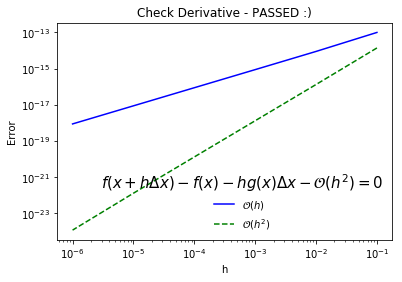

True

In [23]:
Tests.checkDerivative(function_and_deriv, x0=m0, num=6, expectedOrder=2)

In [24]:
# Test Adjoint
u = prob.fields(m0)

v = np.random.rand(len(u))
w = np.random.rand(len(m0))

vJw = v.dot(prob.Jvec(m0, w))
wJtv = w.dot(prob.Jtvec(m0, v))

print(vJw, wJtv, vJw - wJtv)

-7.76450709676e-13 -7.76450709676e-13 0.0


## Invert 

- Use a 20 layer model, starting model and reference model of log(1 Ohm m) 
- we will invert the clean data for now
- assign a 5% error and a 5e-15 floor so that we don't over-fit the zero-crossings

In [25]:
survey = EmpymodSurvey()
survey.pair(prob)

In [26]:
survey.dobs = np.hstack([data.real, data.imag])  # observed data
survey.std = np.abs(survey.dobs)*.05
survey.eps = 5e-15

In [27]:
# regularization
reg = SimPEG.Regularization.Simple(
    SimPEG.Mesh.TensorMesh([len(m0)]), alpha_s=5e-5, alpha_x=1, mref=np.zeros(nlayers+1)
)

# data misfit
dmis = SimPEG.DataMisfit.l2_DataMisfit(survey)

# optimization
opt = SimPEG.Optimization.InexactGaussNewton(maxIter=40)

# inverse problem
invProb = SimPEG.InvProblem.BaseInvProblem(dmis, reg, opt, beta=5)

# directives 
target = SimPEG.Directives.TargetMisfit()
directives = [
#     SimPEG.Directives.BetaEstimate_ByEig(beta0_ratio=5e-2),
    target
]

# inversion
inv = SimPEG.Inversion.BaseInversion(invProb, directiveList=directives)

In [28]:
m0 = np.zeros(nlayers+1) # starting model

In [29]:
# run the inversion 
mrec = inv.run(m0)


    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.00e+00  1.76e+03  0.00e+00  1.76e+03    2.59e+02      0              
   1  5.00e+00  1.74e+03  1.90e+00  1.75e+03    2.06e+03      1              
   2  5.00e+00  1.34e+03  1.90e+00  1.35e+03    6.52e+02      0              
   3  5.00e+00  1.34e+03  1.61e+00  1.34e+03    5.84e+02      4   Skip BFGS  
   4  5.00e+00  1.33e+03  9.26e-01  1.33e+03    5.47e+02      3   Skip BFGS  
   5  5.00e+00  1.33e+03  5.68e-01  1.33e+03    5.60e+02      3   Skip BFGS  
   6  5.00e+00  1.07e+03  3.80e+00  1.09e+03    1.80e+03      1   Skip BFGS  
   7  5.00e+00  5.57e+02  4.41e+00  5.79e+

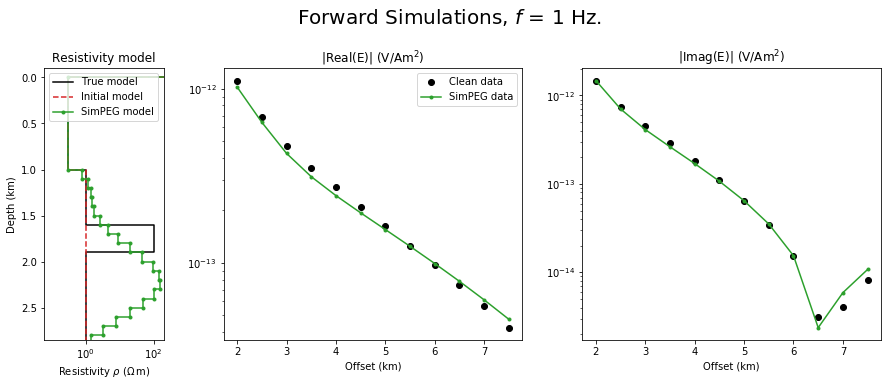

In [30]:
# Plot Resistivities
prho = np.repeat(prob.rho_map * mrec, 2) # resistivities from SimPEG model

# Create arrays for resistivity model
spdepth = np.repeat(mesh.gridN, 2)
spdepth[:-1] = spdepth[1:]
spdepth[-1] = 2*spdepth[-1]

# get observed data
fields = prob.fields(mrec)

# Create figure
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(wspace=.5)
plt.suptitle('Forward Simulations, $f$ = '+str(freq)+' Hz.', y=1.05, fontsize=20)

# plot resistivities
plt.subplot(151)
plt.title('Resistivity model')
plt.plot(pres, pdepth/1000, 'k', label='True model')
plt.plot(np.repeat(prob.rho_map * m0, 2), spdepth/1000, 'C3--', label='Initial model')
plt.plot(prho, spdepth/1000, 'C2.-', label='SimPEG model')
plt.xscale('log')
plt.xlim([.2*np.array(res).min(), 2*np.array(res)[1:].max()])
plt.ylim([1.5*depth[-1]/1000, -0.1])
plt.legend(loc=2)
plt.ylabel('Depth (km)')
plt.xlabel(r'Resistivity $\rho\ (\Omega\,\rm{m})$')

# Plot Amplitude
plt.subplot2grid((1, 5), (0, 1), colspan=2)
plt.title(r'|Real(E)| (V/Am$^2$)')
plt.semilogy(x/1000, np.abs(data.real), 'ko', label='Clean data')
plt.semilogy(x/1000, np.abs(fields[:len(data)]), 'C2.-', label='SimPEG data')
plt.legend(loc='best')
plt.xlabel('Offset (km)')

# Plot Phase
plt.subplot2grid((1, 5), (0, 3), colspan=2)
plt.title(r'|Imag(E)| (V/Am$^2$)')
plt.semilogy(x/1000, np.abs(data.imag), 'ko', label='Clean data')
plt.semilogy(x/1000, np.abs(fields[len(data):]), 'C2.-', label='SimPEG data')
plt.xlabel('Offset (km)')

plt.show()

In [31]:
import printinfo
printinfo.info()